# Logistic Regression

Logistic regression is a classification algorithm. It is used to predict a binary outcome based on a set of independent variables.

In order to implement the model let us recall the loss function of the binary (Univariate) Logistic Regression model

$$ J(\beta)=-\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}\log(h_\beta(x^{(i)}))+(1-y^{(i)})\log(1-h_\beta(x^{(i)}))\right) $$

and the gradient decent update rule is given by

$$ \beta_j^t := \beta_j^{t-1}-\mu\frac{\partial}{\partial \beta_j}J(\beta)
$$

and the update rule for a gradient decent solver of the Logistic Regression model.

$$w_k+1 = w_k + \alpha\frac{d}{d w_k} LL(w_k) = w_k + \alpha x_i(y_i - p_i) =  w_k + \alpha x_i(y_i - \sigma(z_i)) =  w_k + \alpha x_i(y_i - \frac{1}{1+e^{-z_i}}) $$


In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


### Logistic Regression from scratch

In [2]:
class LogisticRegression:

    def __init__(self, method='GD', learning_rate=0.1, num_iterations=1000, track_loss='True'):
        '''
        method: either GD or SGD, indiacting whether to use a regular gradient decent, or an iterative stochastic gradient descent respectively.
        learning_rate: the learning rate to be used
        num_iterations: number of iterations for the gradient decent algorithms (**note** that for stochastic gradient decent, each iteration is 
        interpreted in that aspect as an epoch of going over all the samples, as it is computationaly similar to a single iteration of regular gradient decent)
        track_loss: a boolean stating if to track the loss of the model for each iteration during training; if `True` the model will have a `loss` vector with 
        the loss that was claculated for each of the iterations.
        '''
        self.w = None
        self.b = 0
        self.loss_list = []
        self.lr = learning_rate
        self.iters = num_iterations
        self.track_loss = track_loss
        self.method = method

    def fit(self, X, y):
        '''
        Fit/train model
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        '''
        X, y = X.T, y.reshape(1, y.shape[0])
        m = X.shape[1]
        self.w = np.zeros((X.shape[0], 1))
        if self.method == 'GD':
            self._gd_fit(X, y, m)
        elif self.method == 'SGD':
            self._sgd_fit(X, y, m)
            
    def _gd_fit(self, X, y, m):
        '''
        fitting used for regular gradient decent
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        m: amount of samples in out data
        '''
        for i in range(self.iters):
            y_hat = self._hypothesis(X, y, m)
            if self.track_loss:
                self.loss_list.append(self.score(X.T, y))
                
    def _sgd_fit(self, X, y, m):
        '''
        fitting used for stochastic gradient descent
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        m: amount of samples in out data
        '''
        for i in range(self.iters):
            for j in range(m):
                rnd = np.random.choice(np.arange(m), 1)
                X_rand = X[:,rnd]
                y_rand = y[:,rnd]
                y_hat = self._hypothesis(X_rand, y_rand, 1)
            if self.track_loss:
                self.loss_list.append(self.score(X.T, y))

    def _hypothesis(self, X, y, m):
        '''
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        m: amount of samples in out data
        '''
        y_hat = self.predict_proba(X.T)
        dZ = y_hat - y
        dw = (1/m) * X @ dZ.T
        db = (1/m) * np.sum(dZ)
        self.w = self.w - self.lr * dw
        self.b = self.b - self.lr * db
        return y_hat
    
    @staticmethod
    def _sigmoid(a):
        '''
        sigmoid activation function
        '''
        return 1/(1 + np.exp(-a))
    
    def _loss(self, y_hat, y):
        '''
        y_hat: predicted class label
        y: class label
        '''
        eps = 1e-8
        return -np.sum(np.multiply(np.log(y_hat + eps), y) + np.multiply((1 - y), np.log(1 - y_hat + eps)))/y.shape[1]

    def predict_proba(self, X):
        '''
        Predict probability estimates for class labels
        The returned estimates for all classes are ordered by the label of classes
        X: a matrix of data values (rows are samples, columns are attributes)
        '''
        Z = self.w.T @ X.T + self.b
        return self._sigmoid(Z)
    
    def predict(self, X, threshold=0.5):
        '''
        Predict class labels using fitted/trained model
        X: a matrix of data values (rows are samples, columns are attributes)
        threshold: threshold for when sample gets tagged as positive 
        '''
        return self.predict_proba(X) > threshold
    
    def score(self, X, y):
        '''
        returns MSE of given data
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        '''
        y_pred = self.predict_proba(X)
        return (np.square(y - y_pred)).mean().sum()

## Iris dataset

Lets load the iris dataset and plot the data with the models decision boundary.

In [3]:
iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [4]:
def plot_samples(X, y, gd_model=None, sgd_model=None):
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
  
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    if gd_model is not None:
        probs = gd_model.predict_proba(grid).reshape(xx1.shape)
        plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black',);
    if sgd_model is not None:
        probs = sgd_model.predict_proba(grid).reshape(xx1.shape)
        plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='green',);
    plt.legend()

#### Logistic Regression

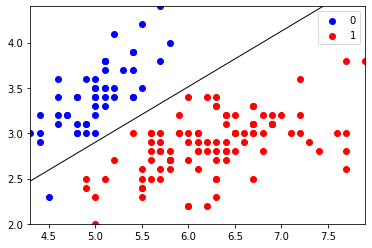

In [5]:
lr = LogisticRegression(num_iterations=1000)
lr.fit(X, y)
pred = lr.predict_proba(X)
plot_samples(X, y, gd_model=lr)

#### Stochastic Logistic Regression 

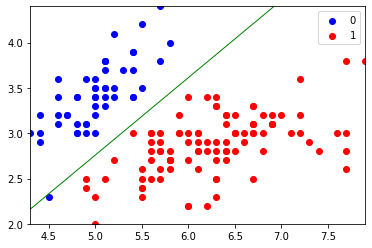

In [6]:
sgdlr = LogisticRegression(method='SGD', num_iterations=1000)
sgdlr.fit(X, y)
pred = sgdlr.predict_proba(X)
plot_samples(X, y, sgd_model=sgdlr)

#### SGD loss vs GD loss

Below we can see that the SGD's loss gets smaller much quicker but its extremely volitile, while the GD loss gets smaller slower but very consistently.

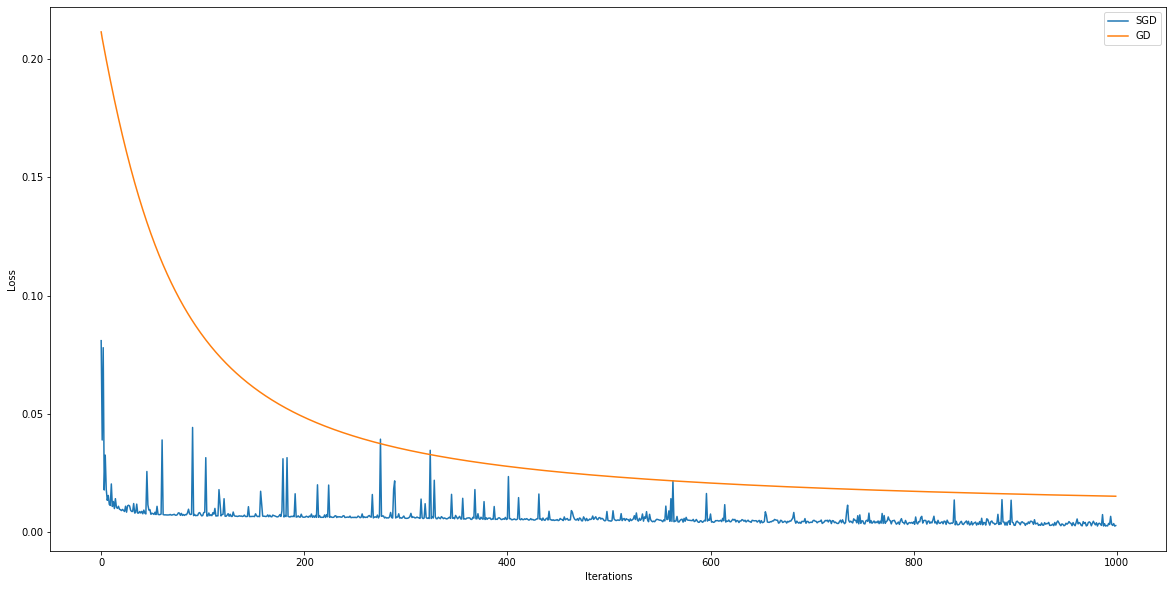

In [7]:
plt.figure(figsize=(20,10))
plt.plot(sgdlr.loss_list)
plt.plot(lr.loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['SGD', 'GD'])